In [1]:
import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import omegaconf

import os
import csv, time
import pickle as pkl
import math
import random
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.lax as lax
import jax.random as jrandom
from jax.scipy.stats import gaussian_kde
# from jax.test_util import check_grads

import numpy as np
from functools import partial
import optax
import distrax
import haiku as hk

import tensorflow as tf
import tensorflow_datasets as tfds

from lfiax.flows.nsf import make_nsf
from lfiax.utils.oed_losses import lf_pce_eig_scan, lf_ace_eig_scan
from lfiax.utils.simulators import sim_linear_data_vmap, sim_linear_data_vmap_theta
# from lfiax.utils.utils import jax_lexpand

from typing import (
    Any,
    Iterator,
    Mapping,
    Optional,
    Tuple,
    Callable,
)

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


In [2]:
# Helper functions
# TODO: Make prior outside of the simulator so you can sample and pass it around
def make_lin_reg_prior():
    theta_shape = (2,)

    mu = jnp.zeros(theta_shape)
    sigma = (3**1) * jnp.ones(theta_shape)

    prior = distrax.Independent(
        distrax.MultivariateNormalDiag(mu, sigma)
    )
    return prior


@jax.jit
def standard_scale(x):
    def single_column_fn(x):
        mean = jnp.mean(x)
        std = jnp.std(x) + 1e-10
        return (x - mean) / std
        
    def multi_column_fn(x):
        mean = jnp.mean(x, axis=0, keepdims=True)
        std = jnp.std(x, axis=0, keepdims=True) + 1e-10
        return (x - mean) / std
        
    scaled_x = jax.lax.cond(
        x.shape[-1] == 1,
        single_column_fn,
        multi_column_fn,
        x
    )
    return scaled_x

@jax.jit
def inverse_standard_scale(scaled_x, shift, scale):
    return (scaled_x + shift) * scale


In [3]:
# Getting hyperparams from hydra config file.

with initialize(version_base=None, config_path="../"):
    cfg = compose(config_name="config")  # overrides=["+db=mysql"]
    print(cfg)

seed = cfg.seed

if cfg.designs.d is None:
    d = jnp.array([])
    xi = jnp.array([cfg.designs.xi])
    d_sim = xi # jnp.array([cfg.designs.xi])
elif cfg.designs.xi is None:
    d = jnp.array([cfg.designs.d])
    xi = jnp.array([])
    d_sim = d
else:
    d = jnp.array([cfg.designs.d])
    xi = jnp.array([cfg.designs.xi])
    d_sim = jnp.concatenate((d, xi), axis=1)

# Bunch of event shapes needed for various functions
len_xi = xi.shape[-1]
xi_shape = (len_xi,)
theta_shape = (2,)
EVENT_SHAPE = (d_sim.shape[-1],)
EVENT_DIM = cfg.param_shapes.event_dim

# contrastive sampling parameters
M = cfg.contrastive_sampling.M
N = cfg.contrastive_sampling.N

# likelihood flow's params
flow_num_layers = cfg.flow_params.num_layers
mlp_num_layers = cfg.flow_params.mlp_num_layers
hidden_size = cfg.flow_params.mlp_hidden_size
num_bins = cfg.flow_params.num_bins

# vi flow's parameters
vi_flow_num_layers = cfg.vi_flow_params.num_layers
vi_mlp_num_layers = cfg.vi_flow_params.mlp_num_layers
vi_hidden_size = cfg.vi_flow_params.mlp_hidden_size
vi_num_bins = cfg.vi_flow_params.num_bins
vi_samples = cfg.vi_flow_params.vi_samples

# Optimization parameters
learning_rate = cfg.optimization_params.learning_rate
xi_lr_init = cfg.optimization_params.xi_learning_rate
training_steps = cfg.optimization_params.training_steps
xi_optimizer = cfg.optimization_params.xi_optimizer
xi_scheduler = cfg.optimization_params.xi_scheduler
xi_lr_end = 1e-4

# Scheduler to use
if xi_scheduler == "None":
    schedule = xi_lr_init

# TODO: reduce boilerplate code.
# @hk.transform_with_state
@hk.without_apply_rng
@hk.transform
def log_prob(x: Array, theta: Array, xi: Array) -> Array:
    # TODO: Pass more nsf parameters from config.yaml
    model = make_nsf(
        event_shape=EVENT_SHAPE,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
        standardize_theta=True,
        use_resnet=True,
        conditional=True
    )
    return model.log_prob(x, theta, xi)

log_prob = log_prob


{'version': '0.0.1', 'seed': 0, 'wandb': {'entity': 'vz_uci', 'project': 'lfiax1D_linReg_ICML'}, 'contrastive_sampling': {'M': 10000, 'N': 200}, 'designs': {'d': None, 'xi': [0.0], 'num_xi': 1}, 'param_shapes': {'theta_shape': 2, 'event_dim': 1}, 'flow_params': {'num_layers': 5, 'mlp_num_layers': 4, 'mlp_hidden_size': 128, 'num_bins': 4}, 'vi_flow_params': {'num_layers': 5, 'mlp_num_layers': 4, 'mlp_hidden_size': 128, 'num_bins': 4, 'vi_samples': 100}, 'optimization_params': {'learning_rate': 0.001, 'xi_learning_rate': 0.01, 'xi_optimizer': 'Adam', 'xi_scheduler': 'None', 'training_steps': 1000, 'xi_lr_end': 0.001, 'lr_values': [0.05, 0.01, 0.005], 'restarts': 3}}


## Optional Pre-training step
Going to train the flow's parameters for 1k steps before optimizing the designs.

In [4]:
@jax.jit
def update(params: hk.Params,
            opt_state: OptState,
            prior_samples: Array, 
            xi_params: hk.Params,
            batch: Array) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    # Normalize the inputs
    log_prob_loss = lambda params, x, theta, xi: -jnp.mean(log_prob.apply(
                params, x, theta, xi))
    xi = jnp.broadcast_to(xi_params['xi'], (len(batch), xi_params['xi'].shape[-1]))
    
    loss, grads = jax.value_and_grad(log_prob_loss)(
        params, batch, prior_samples, xi)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, loss

# Initialize the net's params
prng_seq = hk.PRNGSequence(seed)
params = log_prob.init(
    next(prng_seq),
    np.zeros((1, *EVENT_SHAPE)),
    np.zeros((1, *theta_shape)),
    np.zeros((1, *xi_shape)),
)

optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# TODO: Put this up in the initialization code
if xi_scheduler == "None":
    schedule = xi_lr_init
elif xi_scheduler == "Linear":
    schedule = optax.linear_schedule(xi_lr_init, xi_lr_end, transition_steps=training_steps)
elif xi_scheduler == "Exponential":
    schedule = optax.exponential_decay(
        init_value=xi_lr_init,
        transition_steps=training_steps,
        decay_rate=(xi_lr_end / xi_lr_init) ** (1 / training_steps),
        staircase=False
    )
else:
    raise AssertionError("Specified unsupported scheduler.")

if xi_optimizer == "Adam":
    optimizer2 = optax.adam(learning_rate=schedule)
elif xi_optimizer == "SGD":
    optimizer2 = optax.sgd(learning_rate=schedule)
elif xi_optimizer == "Yogi":
    optimizer2 = optax.yogi(learning_rate=schedule)
elif xi_optimizer == "AdaBelief":
    optimizer2 = optax.adabelief(learning_rate=schedule)

# This could be initialized by a distribution of designs!
params['xi'] = xi
xi_params = {key: value for key, value in params.items() if key == 'xi'}

# Normalize xi values for optimizer
design_min = -10.
design_max = 10.
scale_factor = float(jnp.max(jnp.array([jnp.abs(design_min), jnp.abs(design_max)])))
xi_params_max_norm = {}
xi_params_max_norm['xi'] = jnp.divide(xi_params['xi'], scale_factor)
# xi_params_scaled = (xi_params['xi'] - jnp.mean(xi_params['xi'])) / (jnp.std(xi_params['xi']) + 1e-10)

opt_state_xi = optimizer2.init(xi_params_max_norm)
flow_params = {key: value for key, value in params.items() if key != 'xi'}

x_train, thetas, _, _ = sim_linear_data_vmap(d_sim, 10_000, next(prng_seq))
x_train = x_train.squeeze(0)
x_train_scaled = standard_scale(x_train)

for step in range(300):
    flow_params, opt_state, loss = update(flow_params, opt_state, thetas, xi_params_max_norm, x_train_scaled)
    print(f"STEP: {step}, loss: {loss}")


STEP: 0, loss: 1.4189385175704956
STEP: 1, loss: 1.2623274326324463
STEP: 2, loss: 1.1585851907730103
STEP: 3, loss: 1.095024585723877
STEP: 4, loss: 1.0579965114593506
STEP: 5, loss: 1.0367628335952759
STEP: 6, loss: 1.024481177330017
STEP: 7, loss: 1.017065167427063
STEP: 8, loss: 1.0123929977416992
STEP: 9, loss: 1.0092233419418335
STEP: 10, loss: 1.006983757019043
STEP: 11, loss: 1.0053620338439941
STEP: 12, loss: 1.004069447517395
STEP: 13, loss: 1.003103256225586
STEP: 14, loss: 1.002402663230896
STEP: 15, loss: 1.001784324645996
STEP: 16, loss: 1.0013171434402466
STEP: 17, loss: 1.0009459257125854
STEP: 18, loss: 1.0004844665527344
STEP: 19, loss: 1.0001635551452637
STEP: 20, loss: 0.9997895956039429
STEP: 21, loss: 0.9995466470718384
STEP: 22, loss: 0.999376118183136
STEP: 23, loss: 0.9991673827171326
STEP: 24, loss: 0.9990248680114746
STEP: 25, loss: 0.9989458918571472
STEP: 26, loss: 0.9988747835159302
STEP: 27, loss: 0.9987879395484924
STEP: 28, loss: 0.9987354278564453
STEP

In [5]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(flow_params)

 # Pasting all of the run parameters
@partial(jax.jit, static_argnums=[5,6])
def update_pce(
    flow_params: hk.Params, xi_params: hk.Params, prng_key: PRNGKey, \
    opt_state: OptState, opt_state_xi: OptState, N: int, M: int, \
    designs: Array,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    log_prob_fun = lambda params, x, theta, xi: log_prob.apply(
        params, x, theta, xi)
    
    (loss, (conditional_lp, theta_0, x, x_noiseless, noise, EIG, x_mean, x_std)), grads = jax.value_and_grad(
        lf_pce_eig_scan, argnums=[0,1], has_aux=True)(
        flow_params, xi_params, prng_key, log_prob_fun, designs, N=N, M=M
        )
    
    updates, new_opt_state = optimizer.update(grads[0], opt_state)
    xi_updates, xi_new_opt_state = optimizer2.update(grads[1], opt_state_xi)

    new_params = optax.apply_updates(flow_params, updates)
    new_xi_params = optax.apply_updates(xi_params, xi_updates)
    
    return new_params, new_xi_params, new_opt_state, xi_new_opt_state, loss, grads[1], xi_updates, conditional_lp, theta_0, x, x_noiseless, noise, EIG, x_mean, x_std

for step in range(training_steps):
    flow_params, xi_params_max_norm, opt_state, opt_state_xi, loss, xi_grads, xi_updates, conditional_lp, theta_0, x, x_noiseless, noise, EIG, x_mean, x_std = update_pce(
        flow_params, xi_params_max_norm, next(prng_seq), opt_state, opt_state_xi, N=N, M=M, designs=d_sim, 
    )
    
    if jnp.any(jnp.isnan(xi_grads['xi'])):
        print("Gradients contain NaNs. Breaking out of loop.")
        break
    
    # Calculate the KL-div before updating designs
    like_log_probs = distrax.MultivariateNormalDiag(x_noiseless, noise).log_prob(x)
    kl_div = jnp.abs(jnp.mean(like_log_probs - conditional_lp))
    
    # Setting bounds on the designs
    xi_params_max_norm['xi'] = jnp.clip(
        xi_params_max_norm['xi'], 
        a_min=jnp.divide(design_min, scale_factor), 
        a_max=jnp.divide(design_max, scale_factor)
        )
    
    # Unnormalize to use for simulator params
    xi_params['xi'] = jnp.multiply(xi_params_max_norm['xi'], scale_factor)

    # Update d_sim vector for new simulations
    if jnp.size(d) == 0:
        d_sim = xi_params['xi']
    else:
        d_sim = jnp.concatenate((d, xi_params['xi']), axis=1)
    

    # Saving contents to file
    print(f"STEP: {step:5d}; d_sim: {d_sim}; Xi: {xi_params['xi']}; \
    Xi Updates: {xi_updates['xi']}; Loss: {loss}; EIG: {EIG}; KL Div: {kl_div}")

STEP:     0; d_sim: [[-0.09999913]]; Xi: [[-0.09999913]];     Xi Updates: [[-0.00999991]]; Loss: 1.0014523267745972; EIG: 0.017496049404144287; KL Div: 0.9381985664367676
STEP:     1; d_sim: [[-0.1926572]]; Xi: [[-0.1926572]];     Xi Updates: [[-0.00926581]]; Loss: 0.9459594488143921; EIG: 0.0730055421590805; KL Div: 1.4654138088226318
STEP:     2; d_sim: [[-0.28784204]]; Xi: [[-0.28784204]];     Xi Updates: [[-0.00951848]]; Loss: 0.8511250019073486; EIG: 0.11782249808311462; KL Div: 1.0862972736358643
STEP:     3; d_sim: [[-0.37243724]]; Xi: [[-0.37243724]];     Xi Updates: [[-0.00845952]]; Loss: 0.8034328818321228; EIG: 0.23359984159469604; KL Div: 1.4246841669082642
STEP:     4; d_sim: [[-0.45579976]]; Xi: [[-0.45579976]];     Xi Updates: [[-0.00833625]]; Loss: 0.74327152967453; EIG: 0.22569209337234497; KL Div: 1.4183775186538696
STEP:     5; d_sim: [[-0.5268079]]; Xi: [[-0.5268079]];     Xi Updates: [[-0.00710081]]; Loss: 0.6732203364372253; EIG: 0.2957359552383423; KL Div: 1.6651

## Straight up training LF-PCE with no pre-training

In [ ]:
# Pasting all of the run parameters
@partial(jax.jit, static_argnums=[5,6])
def update_pce(
    flow_params: hk.Params, xi_params: hk.Params, prng_key: PRNGKey, \
    opt_state: OptState, opt_state_xi: OptState, N: int, M: int, \
    designs: Array,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    log_prob_fun = lambda params, x, theta, xi: log_prob.apply(
        params, x, theta, xi)
    
    (loss, (conditional_lp, theta_0, x, x_noiseless, noise, EIG, x_mean, x_std)), grads = jax.value_and_grad(
        lf_pce_eig_scan, argnums=[0,1], has_aux=True)(
        flow_params, xi_params, prng_key, log_prob_fun, designs, N=N, M=M
        )
    
    updates, new_opt_state = optimizer.update(grads[0], opt_state)
    xi_updates, xi_new_opt_state = optimizer2.update(grads[1], opt_state_xi)

    new_params = optax.apply_updates(flow_params, updates)
    new_xi_params = optax.apply_updates(xi_params, xi_updates)
    
    return new_params, new_xi_params, new_opt_state, xi_new_opt_state, loss, grads[1], xi_updates, conditional_lp, theta_0, x, x_noiseless, noise, EIG, x_mean, x_std


# Initialize the net's params
prng_seq = hk.PRNGSequence(seed)
params = log_prob.init(
    next(prng_seq),
    np.zeros((1, *EVENT_SHAPE)),
    np.zeros((1, *theta_shape)),
    np.zeros((1, *xi_shape)),
)

optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

if xi_optimizer == "Adam":
    optimizer2 = optax.adam(learning_rate=schedule)
elif xi_optimizer == "SGD":
    optimizer2 = optax.sgd(learning_rate=schedule)

# This could be initialized by a distribution of designs!
params['xi'] = xi
xi_params = {key: value for key, value in params.items() if key == 'xi'}

# Normalize xi values for optimizer
design_min = -10.
design_max = 10.
scale_factor = float(jnp.max(jnp.array([jnp.abs(design_min), jnp.abs(design_max)])))
xi_params_max_norm = {}
xi_params_max_norm['xi'] = jnp.divide(xi_params['xi'], scale_factor)
# xi_params_scaled = (xi_params['xi'] - jnp.mean(xi_params['xi'])) / (jnp.std(xi_params['xi']) + 1e-10)

opt_state_xi = optimizer2.init(xi_params_max_norm)
flow_params = {key: value for key, value in params.items() if key != 'xi'}
    
EIGs = []
losses = []

for step in range(training_steps):
    flow_params, xi_params_max_norm, opt_state, opt_state_xi, loss, xi_grads, xi_updates, conditional_lp, theta_0, x, x_noiseless, noise, EIG, x_mean, x_std = update_pce(
        flow_params, xi_params_max_norm, next(prng_seq), opt_state, opt_state_xi, N=N, M=M, designs=d_sim,
    )
    
    if jnp.any(jnp.isnan(xi_grads['xi'])):
        print("Gradients contain NaNs. Breaking out of loop.")
        break
    
    # Calculate the KL-div before updating designs
    like_log_probs = distrax.MultivariateNormalDiag(x_noiseless, noise).log_prob(x)
    kl_div = jnp.abs(jnp.mean(like_log_probs - conditional_lp))
    
    # Setting bounds on the designs
    xi_params_max_norm['xi'] = jnp.clip(
        xi_params_max_norm['xi'], 
        a_min=jnp.divide(design_min, scale_factor), 
        a_max=jnp.divide(design_max, scale_factor)
        )
    
    # Unnormalize to use for simulator params
    xi_params['xi'] = jnp.multiply(xi_params_max_norm['xi'], scale_factor)

    # Update d_sim vector for new simulations
    if jnp.size(d) == 0:
        d_sim = xi_params['xi']
    elif jnp.size(xi) == 0:
        d_sim =d_sim
    else:
        d_sim = jnp.concatenate((d, xi_params['xi']), axis=1)

    EIGs.append(EIG)
    losses.append(loss)

    # Saving contents to file
    print(f"STEP: {step:5d}; d_sim: {d_sim}; Xi: {xi_params['xi']}; \
    Xi Updates: {xi_updates['xi']}; Loss: {loss}; EIG: {EIG}; KL Div: {kl_div}")

    # wandb.log({"loss": loss, "xi": xi_params['xi'], "xi_grads": xi_grads['xi'], "kl_divs": kl_div, "EIG": EIG})


# Plotting posteriors
Have a trained likelihood. Now can use importance sampling to get a posterior estimate.
1. Plot out the priors.
2. Simulate "true" data. Can try with and without noise.
2. Get posterior samples using $x_o$ and importance sampling o the likelihood.
3. Plot posteriors.

In [7]:
prior = make_lin_reg_prior()

# Evaluate the log-prior for all prior samples
prior_samples, prior_log_prob = prior.sample_and_log_prob(seed=next(prng_seq), sample_shape=(10_000))


In [8]:
true_theta = jnp.array([[5,2]])

# Simulate real data using true simulator and noise
x_obs, _, _ = sim_linear_data_vmap_theta(d_sim, true_theta, next(prng_seq))


In [9]:
x_obs

DeviceArray([[[60.545624]]], dtype=float32)

In [10]:
xi_test = jnp.broadcast_to(
    xi_params_max_norm['xi'], (len(prior_samples), xi_params['xi'].shape[-1]))

x_obs_test = jnp.broadcast_to(
    x_obs.squeeze(0), (len(prior_samples), x_obs.shape[-1]))

In [11]:
x_obs_test = (x_obs_test - x_mean)/x_std

## Plotting Importance Sampled Posterior

In [12]:
# Getting the posterior by adding the log_probs fo likelihood and prior
liklelihoods = log_prob.apply(flow_params, x_obs_test, prior_samples, xi_test)

In [13]:
log_posterior = liklelihoods + prior_log_prob

# Exponentiate the log-posterior weights to get the unnormalized posterior weights
unnormalized_posterior_weights = jnp.exp(log_posterior)

# Normalize the posterior weights
posterior_weights = unnormalized_posterior_weights / jnp.sum(unnormalized_posterior_weights)

# key = jrandom.PRNGKey(0)
posterior_samples = jrandom.choice(next(prng_seq), prior_samples, shape=(len(prior_samples),), replace=True, p=posterior_weights)


# Better method for getting posterior samples
log_unnormalized_posterior_weights = log_posterior
max_log_weight = jnp.max(log_unnormalized_posterior_weights)
log_posterior_weights_shifted = log_unnormalized_posterior_weights - max_log_weight
unnormalized_posterior_weights = jnp.exp(log_posterior_weights_shifted)
# Normalize the posterior weights
posterior_weights2 = unnormalized_posterior_weights / jnp.sum(unnormalized_posterior_weights)
posterior_samples2 = jrandom.choice(next(prng_seq), prior_samples, shape=(len(prior_samples),), replace=True, p=posterior_weights2)

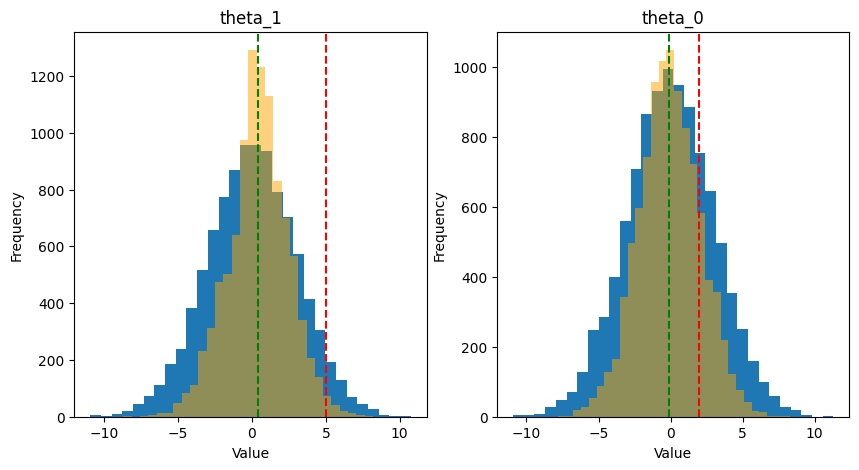

In [14]:
import matplotlib.pyplot as plt
# Use likleihood and priors to get posterior samples
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the first histogram in the first subplot
ax1.hist(prior_samples[:,0], bins=30)
ax1.hist(posterior_samples[:,0], bins=30, alpha=0.5, color='orange', label='Posterior')
ax1.axvline(jnp.mean(posterior_samples[:,0]), color='g', linestyle='--')
ax1.axvline(true_theta[0][0], color='r', linestyle='--')
ax1.set_title("theta_1")
ax1.set_xlabel("Value")
ax1.set_ylabel("Frequency")

# Plot the second histogram in the second subplot
ax2.hist(prior_samples[:,1], bins=30)
ax2.hist(posterior_samples[:,1], bins=30, alpha=0.5, color='orange', label='Posterior')
ax2.axvline(jnp.mean(posterior_samples[:,1]), color='g', linestyle='--')
ax2.axvline(true_theta[0][1], color='r', linestyle='--')
ax2.set_title("theta_0")
ax2.set_xlabel("Value")
ax2.set_ylabel("Frequency")

# Display the figure
plt.show()

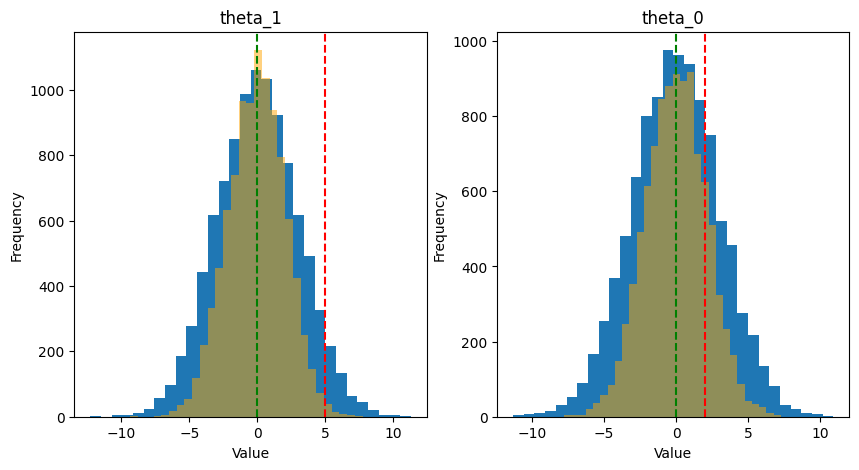

In [48]:
import matplotlib.pyplot as plt
# Use likleihood and priors to get posterior samples
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the first histogram in the first subplot
ax1.hist(prior_samples[:,0], bins=30)
ax1.hist(posterior_samples2[:,0], bins=30, alpha=0.5, color='orange', label='Posterior')
ax1.axvline(jnp.mean(posterior_samples2[:,0]), color='g', linestyle='--')
ax1.axvline(true_theta[0][0], color='r', linestyle='--')
ax1.set_title("theta_1")
ax1.set_xlabel("Value")
ax1.set_ylabel("Frequency")

# Plot the second histogram in the second subplot
ax2.hist(prior_samples[:,1], bins=30)
ax2.hist(posterior_samples2[:,1], bins=30, alpha=0.5, color='orange', label='Posterior')
ax2.axvline(jnp.mean(posterior_samples2[:,1]), color='g', linestyle='--')
ax2.axvline(true_theta[0][1], color='r', linestyle='--')
ax2.set_title("theta_0")
ax2.set_xlabel("Value")
ax2.set_ylabel("Frequency")

# Display the figure
plt.show()

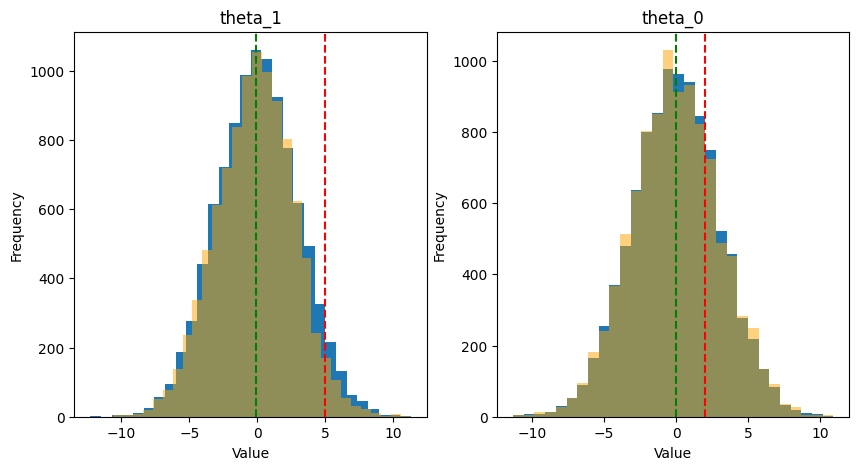

In [49]:
likelihood_samples = jrandom.choice(next(prng_seq), prior_samples, shape=(len(prior_samples),), replace=True, p=jnp.exp(liklelihoods))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the first histogram in the first subplot
ax1.hist(prior_samples[:,0], bins=30)
ax1.hist(likelihood_samples[:,0], bins=30, alpha=0.5, color='orange', label='Posterior')
ax1.axvline(jnp.mean(likelihood_samples[:,0]), color='g', linestyle='--')
ax1.axvline(true_theta[0][0], color='r', linestyle='--')
ax1.set_title("theta_1")
ax1.set_xlabel("Value")
ax1.set_ylabel("Frequency")

# Plot the second histogram in the second subplot
ax2.hist(prior_samples[:,1], bins=30)
ax2.hist(likelihood_samples[:,1], bins=30, alpha=0.5, color='orange', label='Posterior')
ax2.axvline(jnp.mean(likelihood_samples[:,1]), color='g', linestyle='--')
ax2.axvline(true_theta[0][1], color='r', linestyle='--')
ax2.set_title("theta_0")
ax2.set_xlabel("Value")
ax2.set_ylabel("Frequency")

# Display the figure
plt.show()

## Manual SIR Posterior
Do this to get better estimates. Manually doing it first (and getting the posterior plots) before moving on to the automated method.

In [27]:
# Getting the posterior by adding the log_probs fo likelihood and prior
liklelihoods2 = log_prob.apply(flow_params, x_obs_test, posterior_samples2, xi_test)

log_posterior2= liklelihoods2 + log_posterior_weights_shifted

# Better method for getting posterior samples
max_log_weight2 = jnp.max(log_posterior2)
log_posterior_weights_shifted2 = log_posterior2 - max_log_weight2
unnormalized_posterior_weights2 = jnp.exp(log_posterior_weights_shifted2)
# Normalize the posterior weights
posterior_weights3 = unnormalized_posterior_weights2 / jnp.sum(unnormalized_posterior_weights2)
posterior_samples3 = jrandom.choice(next(prng_seq), posterior_samples2, shape=(len(prior_samples),), replace=True, p=posterior_weights3)

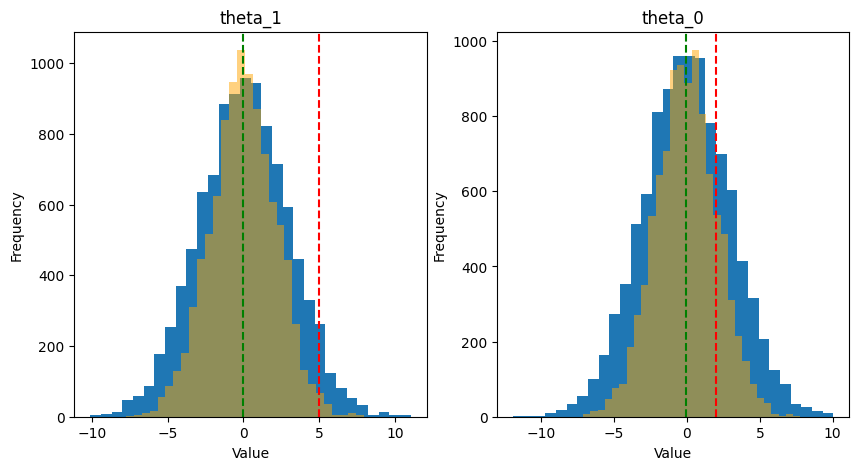

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the first histogram in the first subplot
ax1.hist(prior_samples[:,0], bins=30)
ax1.hist(posterior_samples3[:,0], bins=30, alpha=0.5, color='orange', label='Posterior')
ax1.axvline(jnp.mean(posterior_samples3[:,0]), color='g', linestyle='--')
ax1.axvline(true_theta[0][0], color='r', linestyle='--')
ax1.set_title("theta_1")
ax1.set_xlabel("Value")
ax1.set_ylabel("Frequency")

# Plot the second histogram in the second subplot
ax2.hist(prior_samples[:,1], bins=30)
ax2.hist(posterior_samples3[:,1], bins=30, alpha=0.5, color='orange', label='Posterior')
ax2.axvline(jnp.mean(posterior_samples3[:,1]), color='g', linestyle='--')
ax2.axvline(true_theta[0][1], color='r', linestyle='--')
ax2.set_title("theta_0")
ax2.set_xlabel("Value")
ax2.set_ylabel("Frequency")

# Display the figure
plt.show()

In [29]:
# Getting the posterior by adding the log_probs fo likelihood and prior
liklelihoods3 = log_prob.apply(flow_params, x_obs_test, posterior_samples3, xi_test)

log_posterior3= liklelihoods3 + log_posterior_weights_shifted2

# Better method for getting posterior samples
max_log_weight3 = jnp.max(log_posterior3)
log_posterior_weights_shifted3 = log_posterior3 - max_log_weight3
unnormalized_posterior_weights3 = jnp.exp(log_posterior_weights_shifted3)
# Normalize the posterior weights
posterior_weights4 = unnormalized_posterior_weights3 / jnp.sum(unnormalized_posterior_weights3)
posterior_samples4 = jrandom.choice(next(prng_seq), posterior_samples3, shape=(len(prior_samples),), replace=True, p=posterior_weights4)

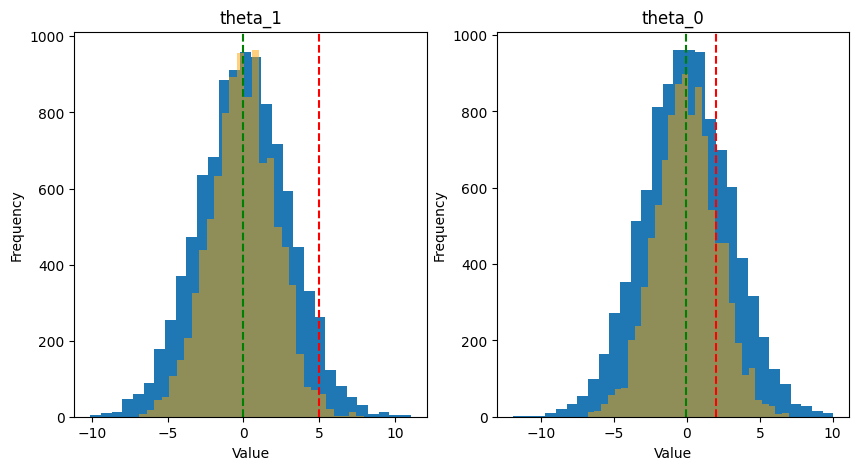

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the first histogram in the first subplot
ax1.hist(prior_samples[:,0], bins=30)
ax1.hist(posterior_samples4[:,0], bins=30, alpha=0.5, color='orange', label='Posterior')
ax1.axvline(jnp.mean(posterior_samples4[:,0]), color='g', linestyle='--')
ax1.axvline(true_theta[0][0], color='r', linestyle='--')
ax1.set_title("theta_1")
ax1.set_xlabel("Value")
ax1.set_ylabel("Frequency")

# Plot the second histogram in the second subplot
ax2.hist(prior_samples[:,1], bins=30)
ax2.hist(posterior_samples4[:,1], bins=30, alpha=0.5, color='orange', label='Posterior')
ax2.axvline(jnp.mean(posterior_samples4[:,1]), color='g', linestyle='--')
ax2.axvline(true_theta[0][1], color='r', linestyle='--')
ax2.set_title("theta_0")
ax2.set_xlabel("Value")
ax2.set_ylabel("Frequency")

# Display the figure
plt.show()

# Auto SIR Posterior

In [15]:
def sir_update(log_likelihood_fn, prior_samples, prior_log_probs, prng_key):
    log_likelihoods = log_likelihood_fn.apply(flow_params, x_obs_test, prior_samples, xi_test)
    
    # Update the importance weights
    new_log_weights = prior_log_probs + log_likelihoods
    
    # Normalize the weights
    max_log_weight = jnp.max(new_log_weights)
    log_weights_shifted = new_log_weights - max_log_weight
    unnormalized_weights = jnp.exp(log_weights_shifted)
    
    # Resample with the updated weights
    posterior_weights = unnormalized_weights / jnp.sum(unnormalized_weights)
    posterior_samples = jrandom.choice(prng_key, prior_samples, shape=(len(prior_samples),), replace=True, p=posterior_weights)
    
    return posterior_samples, posterior_weights

# Prior
prior = make_lin_reg_prior()
prior_samples, prior_log_prob = prior.sample_and_log_prob(seed=next(prng_seq), sample_shape=(10_000))
og_prior_samples = prior_samples.copy()

# Run SIR update
num_iterations = 2
for _ in range(num_iterations):
    prior_samples, prior_log_prob = sir_update(
        log_prob, prior_samples, prior_log_prob, next(prng_seq))

# The final posterior samples
posterior_samples = prior_samples

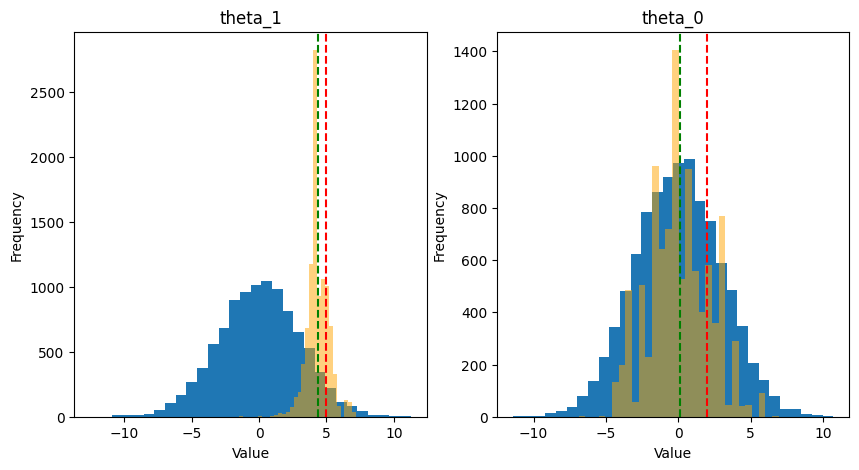

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the first histogram in the first subplot
ax1.hist(og_prior_samples[:,0], bins=30)
ax1.hist(posterior_samples[:,0], bins=30, alpha=0.5, color='orange', label='Posterior')
ax1.axvline(jnp.mean(posterior_samples[:,0]), color='g', linestyle='--')
ax1.axvline(true_theta[0][0], color='r', linestyle='--')
ax1.set_title("theta_1")
ax1.set_xlabel("Value")
ax1.set_ylabel("Frequency")

# Plot the second histogram in the second subplot
ax2.hist(og_prior_samples[:,1], bins=30)
ax2.hist(posterior_samples[:,1], bins=30, alpha=0.5, color='orange', label='Posterior')
ax2.axvline(jnp.mean(posterior_samples[:,1]), color='g', linestyle='--')
ax2.axvline(true_theta[0][1], color='r', linestyle='--')
ax2.set_title("theta_0")
ax2.set_xlabel("Value")
ax2.set_ylabel("Frequency")

# Display the figure
plt.show()

# Plotting posterior predictive
And comparing to prior predictive.

In [19]:
design_space = jnp.linspace(-10, 10, 100)

data_prior = list()
for d_space in design_space:
    
    d = jnp.array([[d_space]])

    y, _, _ = sim_linear_data_vmap_theta(d, og_prior_samples, next(prng_seq))
    data_prior.append(y)
data_prior = jnp.array(data_prior)


data_post = list()
for d_space in design_space:
    
    d = jnp.array([[d_space]])

    y, _, _ = sim_linear_data_vmap_theta(d, posterior_samples, next(prng_seq))
    data_post.append(y)
data_post = jnp.array(data_post)



mean_data_1 = jnp.mean(data_prior, axis=2).reshape(-1)
std_data_1 = jnp.std(data_prior, axis=2).reshape(-1)

mean_data_1_post = jnp.mean(data_post, axis=2).reshape(-1)
std_data_1_post = jnp.std(data_post, axis=2).reshape(-1)


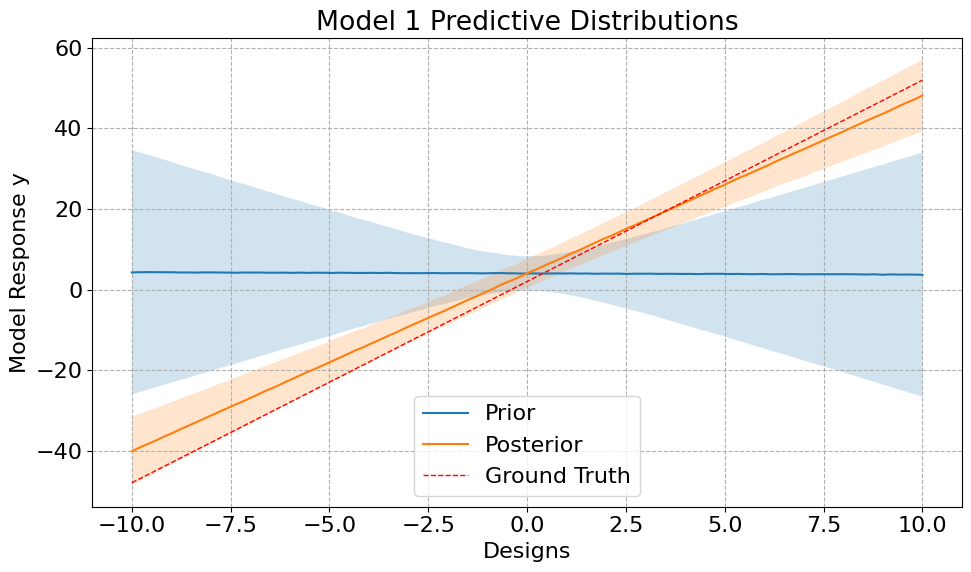

In [21]:
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams.update({'font.size': 16})

# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
# plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 6))

# MODEL 1

ax = fig.add_subplot(111)

ax.plot(design_space, mean_data_1, label='Prior')
ax.fill_between(design_space, mean_data_1 - std_data_1, mean_data_1 + std_data_1, alpha=0.2)
ax.plot(design_space, mean_data_1_post, label='Posterior')
ax.fill_between(design_space, mean_data_1_post - std_data_1_post, mean_data_1_post + std_data_1_post, alpha=0.2)
xx = jnp.linspace(-10, 10, 1000)
ax.plot(xx, 2 + 5*xx, ls='--', c='r', lw=1, label='Ground Truth')

ax.set_xlabel('Designs')
ax.set_ylabel('Model Response y')
ax.set_title('Model 1 Predictive Distributions')
ax.legend(loc='lower center')
ax.grid(True, ls='--')

plt.tight_layout()



# Making NSF VI flow that can be sampled and evaluated

In [ ]:
# Get previous flow_params and wrap them up with `make_nsf` function

class NormalizingFlow(hk.Module):
    def __init__(self, event_shape, num_layers, hidden_sizes, num_bins, standardize_theta=False,
                 use_resnet=True, conditional=True, base_dist="gaussian", name=None):
        super().__init__(name=name)
        self.flow_model = make_nsf(event_shape, num_layers, hidden_sizes, num_bins,
                                   standardize_theta, use_resnet, conditional, base_dist)

    def sample(self, rng, n_samples, shift, scale):
        samples = self.flow_model._sample_n(key=rng, n=[n_samples])
        return inverse_standard_scale(samples, shift, scale)

    def log_prob(self, theta, shift, scale):
        theta_scaled = standard_scale(theta)
        return self.flow_model.log_prob(theta_scaled)

def create_normalizing_flow(event_shape, num_layers, hidden_sizes, num_bins,
                            standardize_theta=False, use_resnet=True, conditional=True, base_dist="gaussian"):
    return NormalizingFlow(event_shape, num_layers, hidden_sizes, num_bins, standardize_theta,
                           use_resnet, conditional, base_dist)

# Haiku transform
nf_transform = hk.without_apply_rng(hk.transform(create_normalizing_flow))


# Training Likelihood for SNL
We now have a likelihood approximation with an optimal experimental design. Let's see if we can get a better approximation at that design by further tuning the likelihood. This would be SNL.

In [39]:
prior = make_lin_reg_prior()

og_prior_samples, og_prior_log_prob = prior.sample_and_log_prob(seed=next(prng_seq), sample_shape=(10_000))

In [40]:
og_flow_params = flow_params.copy()

In [44]:
xi_params_max_norm

{'xi': DeviceArray([[0.9706783]], dtype=float32)}

In [45]:
# Reset optimizer state
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(flow_params)

@jax.jit
def update(params: hk.Params,
            opt_state: OptState,
            prior_samples: Array, 
            xi_params: hk.Params,
            batch: Array) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    # Normalize the inputs
    log_prob_loss = lambda params, x, theta, xi: -jnp.mean(log_prob.apply(
                params, x, theta, xi))
    xi = jnp.broadcast_to(xi_params['xi'], (len(batch), xi_params['xi'].shape[-1]))
    
    loss, grads = jax.value_and_grad(log_prob_loss)(
        params, batch, prior_samples, xi)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, loss

x_train, _, _ = sim_linear_data_vmap_theta(d_sim, og_prior_samples, next(prng_seq))
x_train = x_train.squeeze(0)
x_train_scaled = standard_scale(x_train)

for step in range(1_000):
    flow_params, opt_state, loss = update(
        flow_params, opt_state, og_prior_samples, xi_params_max_norm, x_train_scaled)
    print(f"STEP: {step}, loss: {loss}")


STEP: 0, loss: 1.1662362813949585
STEP: 1, loss: 1.0631200075149536
STEP: 2, loss: 1.0263386964797974
STEP: 3, loss: 1.0115158557891846
STEP: 4, loss: 1.005104660987854
STEP: 5, loss: 1.002152442932129
STEP: 6, loss: 1.0007011890411377
STEP: 7, loss: 0.9999487996101379
STEP: 8, loss: 0.9995384216308594
STEP: 9, loss: 0.9992992877960205
STEP: 10, loss: 0.9991536736488342
STEP: 11, loss: 0.9990623593330383
STEP: 12, loss: 0.9990038871765137
STEP: 13, loss: 0.9989644289016724
STEP: 14, loss: 0.9989370703697205
STEP: 15, loss: 0.9989177584648132
STEP: 16, loss: 0.998903214931488
STEP: 17, loss: 0.9988923668861389
STEP: 18, loss: 0.9988843202590942
STEP: 19, loss: 0.9988781213760376
STEP: 20, loss: 0.9988731145858765
STEP: 21, loss: 0.998869001865387
STEP: 22, loss: 0.9988657832145691
STEP: 23, loss: 0.9988630414009094
STEP: 24, loss: 0.9988608956336975
STEP: 25, loss: 0.998859167098999
STEP: 26, loss: 0.9988574981689453
STEP: 27, loss: 0.998856246471405
STEP: 28, loss: 0.99885493516922
STE

KeyboardInterrupt: 

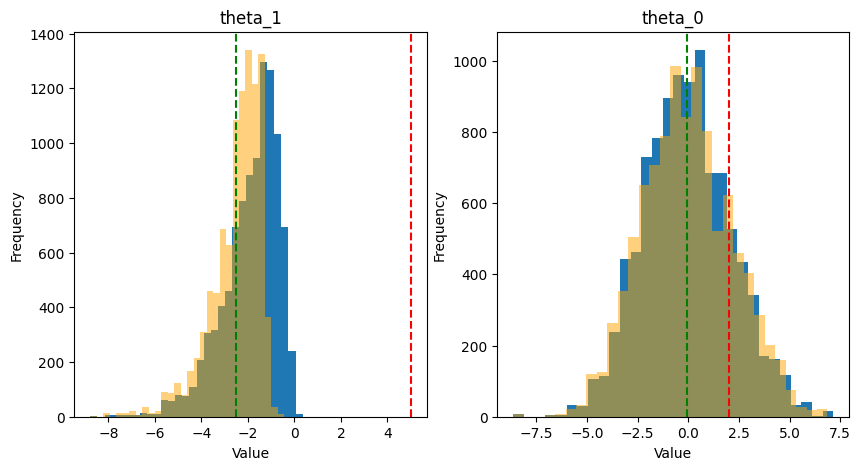

In [46]:
# Remember here prior_samples is previous round's posterior
liklelihoods = log_prob.apply(flow_params, x_obs_test, prior_samples, xi_test)

likelihood_samples = jrandom.choice(
    next(prng_seq), prior_samples, shape=(len(prior_samples),), replace=True, p=jnp.exp(liklelihoods))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the first histogram in the first subplot
ax1.hist(prior_samples[:,0], bins=30)
ax1.hist(likelihood_samples[:,0], bins=30, alpha=0.5, color='orange', label='Posterior')
ax1.axvline(jnp.mean(likelihood_samples[:,0]), color='g', linestyle='--')
ax1.axvline(true_theta[0][0], color='r', linestyle='--')
ax1.set_title("theta_1")
ax1.set_xlabel("Value")
ax1.set_ylabel("Frequency")

# Plot the second histogram in the second subplot
ax2.hist(prior_samples[:,1], bins=30)
ax2.hist(likelihood_samples[:,1], bins=30, alpha=0.5, color='orange', label='Posterior')
ax2.axvline(jnp.mean(likelihood_samples[:,1]), color='g', linestyle='--')
ax2.axvline(true_theta[0][1], color='r', linestyle='--')
ax2.set_title("theta_0")
ax2.set_xlabel("Value")
ax2.set_ylabel("Frequency")

# Display the figure
plt.show()

In [60]:
# Doing SIR again with new likelihood function params
# Run SIR update
num_iterations = 20
for _ in range(num_iterations):
    prior_samples, prior_log_prob = sir_update(
        log_prob, prior_samples, prior_log_prob, next(prng_seq))

# The final posterior samples
posterior_samples = prior_samples

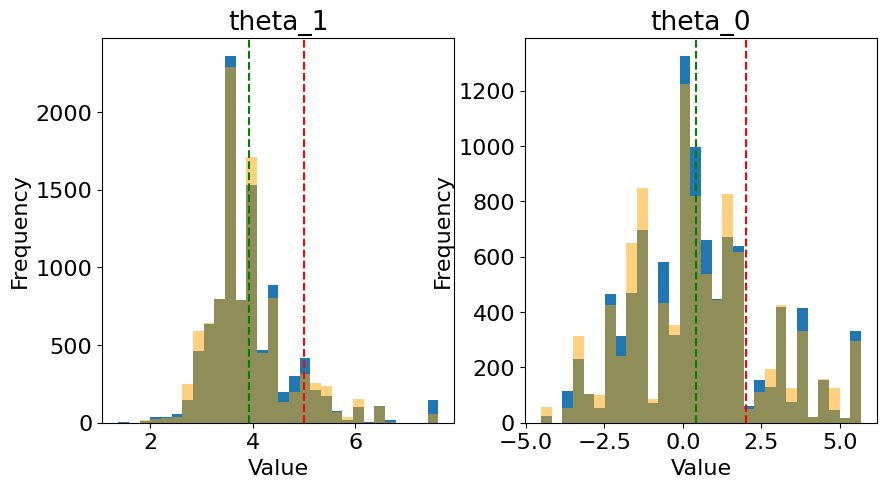

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the first histogram in the first subplot
ax1.hist(likelihood_samples[:,0], bins=30)
ax1.hist(posterior_samples[:,0], bins=30, alpha=0.5, color='orange', label='Posterior')
ax1.axvline(jnp.mean(posterior_samples[:,0]), color='g', linestyle='--')
ax1.axvline(true_theta[0][0], color='r', linestyle='--')
ax1.set_title("theta_1")
ax1.set_xlabel("Value")
ax1.set_ylabel("Frequency")

# Plot the second histogram in the second subplot
ax2.hist(likelihood_samples[:,1], bins=30)
ax2.hist(posterior_samples[:,1], bins=30, alpha=0.5, color='orange', label='Posterior')
ax2.axvline(jnp.mean(posterior_samples[:,1]), color='g', linestyle='--')
ax2.axvline(true_theta[0][1], color='r', linestyle='--')
ax2.set_title("theta_0")
ax2.set_xlabel("Value")
ax2.set_ylabel("Frequency")

# Display the figure
plt.show()

# Estimating VI Posterior

In [ ]:
# ---------------------------------
# Approximate the posterior using VI
prior = make_lin_reg_prior()

# Evaluate the log-prior for all prior samples
prior_samples, prior_log_prob = prior.sample_and_log_prob(seed=next(prng_seq), sample_shape=(vi_samples))

xi = jnp.broadcast_to(xi_params['xi'], (vi_samples, xi_params['xi'].shape[-1]))

# Simulate data using the prior
x, prior_samples, _, _ = sim_linear_data_vmap(d_sim, vi_samples, next(prng_seq))
# TODO: Figure out prior_samples shape and simulate the correct response
log_likelihoods = log_prob.apply(flow_params, x, prior_samples, xi)

vi_params = vi_log_prob.init(
    next(prng_seq),
    np.zeros((1, *theta_shape)),
)

vi_optimizer = optax.adam(learning_rate)

@jax.jit
def vi_objective(vi_params, prior_samples, likelihood_log_probs, prior_log_probs):
    log_q = vi_log_prob.apply(vi_params, prior_samples)
    log_joint = likelihood_log_probs + prior_log_probs
    return -jnp.mean(log_joint - log_q)

@jax.jit
def vi_update(params: hk.Params,
            opt_state: OptState,
            prior_samples,
            likelihood_log_probs,
            prior_log_probs,
            ) -> Tuple[hk.Params, OptState]:
    """Single SGD update step of the VI posterior."""
    grads = jax.grad(vi_objective)(
        vi_params, prior_samples, likelihood_log_probs, prior_log_probs)
    updates, new_opt_state = vi_optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

vi_opt_state = vi_optimizer.init(vi_params)

for i in range(10):
    vi_params, vi_opt_state = vi_update(
        vi_params, vi_opt_state, prior_samples, log_likelihoods, prior_log_prob)

# Sample from the optimized variational family to approximate the posterior
# TODO: Implement sample function to use for evaluation metrics
shift = jnp.mean(prior_samples)
scale = jnp.std(prior_samples)
posterior_samples = vi_sample.apply(
    vi_params, next(prng_seq), num_samples=1000, shift=shift, scale=scale
    )

# ------------------------------
# Posterior checks
# 1. PPC check
# 1a. Generate samples x_pp and compare with x_o.
# Simulate data using posterior samples - invalid if no previous designs seen.
# TODO: Make simulator function that just takes d, x, and theta - not random.
x_pp, _, _ = sim_linear_data_vmap_theta(d_sim, posterior_samples, next(prng_seq))
# 1b. Plot.

# SBC using VI posteriors
Need to create 100 VI posteriors that are all trained using different simulated prior samples (1_000 each). Then use those samples to generate observations. Perform posterior inference given those samples. Ah, need to do the SNLE -> VI twostep process altogether here. Yikes... Ok, I'll start with 10 locally and debug it here. Clearly have to get this onto the slurm cluster to get it to work. 

# Estimating Conditional VI Posterior
Previous one was just estimating the posterior using ELBO of the posterior. I actually need to amortize the posterior. This means using the equivalent of APT, or, SNPE-C here. Funny because that is also what I think is the same as LF-ACE. Can then use that to amortize the posterior for LF-PCE and perform SBC. 

To implement, I'm just reusing the the conditioner but using $\xi$ instead of $\theta$ to avoid confusion. The flow will be on the parameters $\theta$ themselves. So, it'll be $p(\theta|\xi = x)$. Since I'm not using $\theta$, I can avoid headaches by just setting `standardize_theta=False`. Everything else should work as normal.

For the loss function, I think I can use LF-ACE but need to divide the posterior estimate by the prior - at least according to Durkan's paper. I'm doing with replacement but odds of a collision are very small. Oh, it's not LF-ACE, but rather a version of it that normalizes to become LF-PCE. Still, I'm going to train just on LF-PCE version of it.

### Training Conditional VI
1. vary steps of SIR. About 20 is known "good" posterior but may need to test with different settings if the SBC is not good. 
2. Test various SBC ranks and stuff.

In [ ]:
prior = make_lin_reg_prior()

# Evaluate the log-prior for all prior samples
prior_samples, prior_log_prob = prior.sample_and_log_prob(seed=next(prng_seq), sample_shape=(vi_samples))

xi = jnp.broadcast_to(xi_params['xi'], (vi_samples, xi_params['xi'].shape[-1]))

# Simulate data using the prior
x, prior_samples, _, _ = sim_linear_data_vmap(d_sim, vi_samples, next(prng_seq))
# TODO: Figure out prior_samples shape and simulate the correct response
log_likelihoods = log_prob.apply(flow_params, x, prior_samples, xi)

vi_params = vi_log_prob.init(
    next(prng_seq),
    np.zeros((1, *theta_shape)),
)

vi_optimizer = optax.adam(learning_rate)

@jax.jit
def vi_objective(vi_params, prior_samples, likelihood_log_probs, prior_log_probs):
    log_q = vi_log_prob.apply(vi_params, prior_samples)
    log_joint = likelihood_log_probs + prior_log_probs
    return -jnp.mean(log_joint - log_q)

@jax.jit
def vi_update(params: hk.Params,
            opt_state: OptState,
            prior_samples,
            likelihood_log_probs,
            prior_log_probs,
            ) -> Tuple[hk.Params, OptState]:
    """Single SGD update step of the VI posterior."""
    grads = jax.grad(lf_ace_eig_scan)(
        vi_params, prior_samples, likelihood_log_probs, prior_log_probs)
    updates, new_opt_state = vi_optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

vi_opt_state = vi_optimizer.init(vi_params)

for i in range(10):
    vi_params, vi_opt_state = vi_update(
        vi_params, vi_opt_state, prior_samples, log_likelihoods, prior_log_prob)

# Sample from the optimized variational family to approximate the posterior
# TODO: Implement sample function to use for evaluation metrics
shift = jnp.mean(prior_samples)
scale = jnp.std(prior_samples)
posterior_samples = vi_sample.apply(
    vi_params, next(prng_seq), num_samples=1000, shift=shift, scale=scale
    )

# ------------------------------
# Posterior checks
# 1. PPC check
# 1a. Generate samples x_pp and compare with x_o.
# Simulate data using posterior samples - invalid if no previous designs seen.
# TODO: Make simulator function that just takes d, x, and theta - not random.
x_pp, _, _ = sim_linear_data_vmap_theta(d_sim, posterior_samples, next(prng_seq))
# 1b. Plot.

## Checking SIR posterior with various observed values
This is where I figured out that you have to correct for the Gaussian distribution imposed on the likelihood - switch negative values to be positive, and vice versa.

In [34]:
from lfiax.utils.utils import sir_update

# 1. Perform SIR using the trained likelihood - use SIR function in utities
true_theta = jnp.array([[5.,2.]])

prior = make_lin_reg_prior()

# Evaluate the log-prior for all prior samples
prior_samples, prior_log_prob = prior.sample_and_log_prob(seed=next(prng_seq), sample_shape=(10_000))

# Simulate real data using true simulator and noise
x_obs, _, _ = sim_linear_data_vmap_theta(d_sim, true_theta, next(prng_seq))
x_obs = jnp.array([[[-70.]]])

xi_test = jnp.broadcast_to(
    xi_params_max_norm['xi'], (len(prior_samples), xi_params['xi'].shape[-1]))

x_obs_test = jnp.broadcast_to(
    x_obs.squeeze(0), (len(prior_samples), x_obs.shape[-1]))

x_obs_test = -jnp.abs((x_obs_test - x_mean)/x_std)


In [35]:
x_mean

DeviceArray(-57.99601, dtype=float32)

In [36]:
x_obs_test

DeviceArray([[-0.12102406],
             [-0.12102406],
             [-0.12102406],
             ...,
             [-0.12102406],
             [-0.12102406],
             [-0.12102406]], dtype=float32)

In [37]:
# Prior
prior = make_lin_reg_prior()
prior_samples, prior_log_prob = prior.sample_and_log_prob(
  seed=next(prng_seq), sample_shape=(10_000))
og_prior_samples = prior_samples.copy()

# Run SIR update
num_iterations = 3
for _ in range(num_iterations):
    prior_samples, prior_log_prob = sir_update(
        log_prob, prior_samples, prior_log_prob, next(prng_seq), flow_params, x_obs_test, xi_test)

# The final posterior samples
posterior_samples = prior_samples


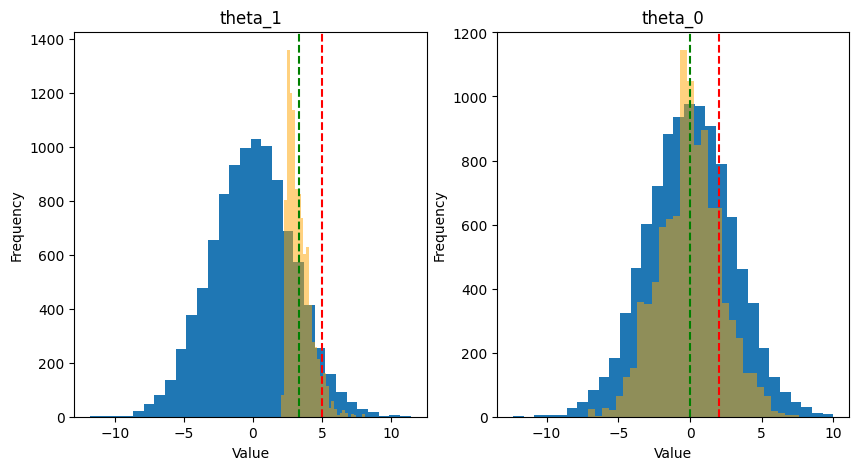

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

# Plot the first histogram in the first subplot
ax1.hist(og_prior_samples[:,0], bins=30)
ax1.hist(posterior_samples[:,0], bins=30, alpha=0.5, color='orange', label='Posterior')
ax1.axvline(jnp.mean(posterior_samples[:,0]), color='g', linestyle='--')
ax1.axvline(true_theta[0][0], color='r', linestyle='--')
ax1.set_title("theta_1")
ax1.set_xlabel("Value")
ax1.set_ylabel("Frequency")

# Plot the second histogram in the second subplot
ax2.hist(og_prior_samples[:,1], bins=30)
ax2.hist(posterior_samples[:,1], bins=30, alpha=0.5, color='orange', label='Posterior')
ax2.axvline(jnp.mean(posterior_samples[:,1]), color='g', linestyle='--')
ax2.axvline(true_theta[0][1], color='r', linestyle='--')
ax2.set_title("theta_0")
ax2.set_xlabel("Value")
ax2.set_ylabel("Frequency")

# Display the figure
plt.show()

# 2. Train a conditional VI Posterior

In [189]:
# Creating the function to parallelize with joblib
# Pasting all of the run parameters
def create_locals(d):
    locals_dict = {}
    for key, value in d.items():
        if isinstance(value, dict):
            # If the value is a dictionary, recursively create local variables for its leaf nodes
            locals_dict.update(create_locals(value))
        else:
            # If the value is not a dictionary, create a local variable with the key as its name
            locals_dict[key] = value
    return locals_dict


def train_single_model(seed):
    # Call the recursive function to create local variables for all leaf nodes of the dictionary
    locals_dict = create_locals(omegaconf.OmegaConf.to_container(cfg, resolve=True))
    
    # Creating pre-processing of local variables -------
    if locals_dict['d'] is None:
        d = jnp.array([])
        xi = jnp.array([locals_dict['xi']])
        d_sim = xi # jnp.array([cfg.designs.xi])
    else:
        d = jnp.array([locals_dict['d']])
        xi = jnp.array([locals_dict['xi']])
        d_sim = jnp.concatenate((d, xi), axis=1)

    # Bunch of event shapes needed for various functions
    len_xi = xi.shape[-1]
    xi_shape = (len_xi,)
    theta_shape = (2,)
    EVENT_SHAPE = (d_sim.shape[-1],)
    # EVENT_DIM = cfg.param_shapes.event_dim

    # contrastive sampling parameters
    M = locals_dict['M']
    N = locals_dict['N']

    # likelihood flow's params
    flow_num_layers = locals_dict['num_layers']
    mlp_num_layers = locals_dict['mlp_num_layers']
    hidden_size = locals_dict['mlp_hidden_size']
    num_bins = locals_dict['num_bins']

    # vi flow's parameters
    vi_flow_num_layers = locals_dict['num_layers']
    vi_mlp_num_layers = locals_dict['mlp_num_layers']
    vi_hidden_size = locals_dict['mlp_hidden_size']
    vi_num_bins = locals_dict['num_bins']
    vi_samples = locals_dict['vi_samples']

    # Optimization parameters
    learning_rate = locals_dict['learning_rate']
    xi_lr_init = locals_dict['xi_learning_rate']
    training_steps = locals_dict['training_steps']
    xi_optimizer = locals_dict['xi_optimizer']
    xi_scheduler = locals_dict['xi_scheduler']
    xi_lr_end = 1e-4
    # -------------------------

    
    @partial(jax.jit, static_argnums=[5,6])
    def update_pce(
        flow_params: hk.Params, xi_params: hk.Params, prng_key: PRNGKey, \
        opt_state: OptState, opt_state_xi: OptState, N: int, M: int, \
        designs: Array,
    ) -> Tuple[hk.Params, OptState]:
        """Single SGD update step."""
        log_prob_fun = lambda params, x, theta, xi: log_prob.apply(
            params, x, theta, xi)
        
        (loss, (conditional_lp, theta_0, x, x_noiseless, noise, EIG)), grads = jax.value_and_grad(
            lf_pce_eig_scan, argnums=[0,1], has_aux=True)(
            flow_params, xi_params, prng_key, log_prob_fun, designs, N=N, M=M
            )
        
        updates, new_opt_state = optimizer.update(grads[0], opt_state)
        xi_updates, xi_new_opt_state = optimizer2.update(grads[1], opt_state_xi)

        new_params = optax.apply_updates(flow_params, updates)
        new_xi_params = optax.apply_updates(xi_params, xi_updates)
        
        return new_params, new_xi_params, new_opt_state, xi_new_opt_state, loss, grads[1], xi_updates, conditional_lp, theta_0, x, x_noiseless, noise, EIG

    # Initialize the net's params
    prng_seq = hk.PRNGSequence(seed)
    params = log_prob.init(
        next(prng_seq),
        np.zeros((1, *EVENT_SHAPE)),
        np.zeros((1, *theta_shape)),
        np.zeros((1, *xi_shape)),
    )

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    # TODO: Put this up in the initialization code
    if xi_scheduler == "None":
        schedule = xi_lr_init
    elif xi_scheduler == "Linear":
        schedule = optax.linear_schedule(xi_lr_init, xi_lr_end, transition_steps=training_steps)
    elif xi_scheduler == "Exponential":
        schedule = optax.exponential_decay(
            init_value=xi_lr_init,
            transition_steps=training_steps,
            decay_rate=(xi_lr_end / xi_lr_init) ** (1 / training_steps),
            staircase=False
        )
    else:
        raise AssertionError("Specified unsupported scheduler.")

    if xi_optimizer == "Adam":
        optimizer2 = optax.adam(learning_rate=schedule)
    elif xi_optimizer == "SGD":
        optimizer2 = optax.sgd(learning_rate=schedule)
    elif xi_optimizer == "Yogi":
        optimizer2 = optax.yogi(learning_rate=schedule)
    elif xi_optimizer == "AdaBelief":
        optimizer2 = optax.adabelief(learning_rate=schedule)

    # This could be initialized by a distribution of designs!
    params['xi'] = xi
    # BUG: For some reason locals() would not update the local `xi` parameter, so using it directly.
    # params['xi'] = jnp.array(locals_dict['xi'])
    # print(params['xi'])
    xi_params = {key: value for key, value in params.items() if key == 'xi'}

    # Normalize xi values for optimizer
    design_min = -10.
    design_max = 10.
    scale_factor = float(jnp.max(jnp.array([jnp.abs(design_min), jnp.abs(design_max)])))
    xi_params_max_norm = {}
    xi_params_max_norm['xi'] = jnp.divide(xi_params['xi'], scale_factor)
    # xi_params_scaled = (xi_params['xi'] - jnp.mean(xi_params['xi'])) / (jnp.std(xi_params['xi']) + 1e-10)

    opt_state_xi = optimizer2.init(xi_params_max_norm)
    flow_params = {key: value for key, value in params.items() if key != 'xi'}

    for step in range(training_steps):
        flow_params, xi_params_max_norm, opt_state, opt_state_xi, loss, xi_grads, xi_updates, conditional_lp, theta_0, x, x_noiseless, noise, EIG = update_pce(
            flow_params, xi_params_max_norm, next(prng_seq), opt_state, opt_state_xi, N=N, M=M, designs=d_sim, 
        )
        
        if jnp.any(jnp.isnan(xi_grads['xi'])):
            print("Gradients contain NaNs. Breaking out of loop.")
            break
        
        # Calculate the KL-div before updating designs
        like_log_probs = distrax.MultivariateNormalDiag(x_noiseless, noise).log_prob(x)
        kl_div = jnp.mean(like_log_probs - conditional_lp)
        
        # Setting bounds on the designs
        xi_params_max_norm['xi'] = jnp.clip(
            xi_params_max_norm['xi'], 
            a_min=jnp.divide(design_min, scale_factor), 
            a_max=jnp.divide(design_max, scale_factor)
            )
        
        # Unnormalize to use for simulator params
        xi_params['xi'] = jnp.multiply(xi_params_max_norm['xi'], scale_factor)

        # Update d_sim vector for new simulations
        if jnp.size(d) == 0:
            d_sim = xi_params['xi']
        else:
            d_sim = jnp.concatenate((d, xi_params['xi']), axis=1)

        # Saving contents to file
        print(f"STEP: {step:5d}; d_sim: {d_sim}; Xi: {xi_params['xi']}; \
        Xi Updates: {xi_updates['xi']}; Loss: {loss}; EIG: {EIG}; KL Div: {kl_div}")

        # wandb.log({"loss": loss, "xi": xi_params['xi'], "xi_grads": xi_grads['xi'], "kl_divs": kl_div, "EIG": EIG})

    # ---------------------------------
    # Approximate the posterior using VI
    prior = make_lin_reg_prior()

    # Evaluate the log-prior for all prior samples
    prior_samples, prior_log_prob = prior.sample_and_log_prob(seed=next(prng_seq), sample_shape=(vi_samples))

    xi = jnp.broadcast_to(xi_params['xi'], (vi_samples, xi_params['xi'].shape[-1]))

    # Simulate data using the prior
    x, prior_samples, _, _ = sim_linear_data_vmap(d_sim, vi_samples, next(prng_seq))
    # TODO: Figure out prior_samples shape and simulate the correct response
    log_likelihoods = log_prob.apply(flow_params, x, prior_samples, xi)

    vi_params = vi_log_prob.init(
        next(prng_seq),
        np.zeros((1, *theta_shape)),
    )

    vi_optimizer = optax.adam(learning_rate)

    @jax.jit
    def vi_objective(vi_params, prior_samples, likelihood_log_probs, prior_log_probs):
        log_q = vi_log_prob.apply(vi_params, prior_samples)
        log_joint = likelihood_log_probs + prior_log_probs
        return -jnp.mean(log_joint - log_q)

    @jax.jit
    def vi_update(params: hk.Params,
                opt_state: OptState,
                prior_samples,
                likelihood_log_probs,
                prior_log_probs,
                ) -> Tuple[hk.Params, OptState]:
        """Single SGD update step of the VI posterior."""
        grads = jax.grad(vi_objective)(
            vi_params, prior_samples, likelihood_log_probs, prior_log_probs)
        updates, new_opt_state = vi_optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state

    vi_opt_state = vi_optimizer.init(vi_params)

    for i in range(10):
        vi_params, vi_opt_state = vi_update(
            vi_params, vi_opt_state, prior_samples, log_likelihoods, prior_log_prob)

    # Sample from the optimized variational family to approximate the posterior
    # TODO: Implement sample function to use for evaluation metrics
    shift = jnp.mean(prior_samples)
    scale = jnp.std(prior_samples)
    # posterior_samples = vi_sample.apply(
    #     vi_params, next(prng_seq), num_samples=1000, shift=shift, scale=scale
    #     )
    return vi_params
    


In [177]:
import joblib

# Define the number of models to train in parallel
num_models = 10

# Initialize a list of random keys to use for each model
# rng_keys = jrandom.split(jax.random.PRNGKey(0), num_models)
rng_keys = [i for i in range(10)]

In [98]:
delattr(cfg, 'seed')

In [190]:
# Define the number of processes to use for training
num_processes = -1

# Parallelize the training of the models using joblib
results = joblib.Parallel(n_jobs=num_processes)(
    joblib.delayed(train_single_model)(rng_key)
    for rng_key in rng_keys
)

dict_keys(['version', 'entity', 'project', 'M', 'N', 'd', 'xi', 'theta_shape', 'event_dim', 'num_layers', 'mlp_num_layers', 'mlp_hidden_size', 'num_bins', 'vi_samples', 'learning_rate', 'xi_learning_rate', 'xi_optimizer', 'xi_scheduler', 'training_steps'])dict_keys(['version', 'entity', 'project', 'M', 'N', 'd', 'xi', 'theta_shape', 'event_dim', 'num_layers', 'mlp_num_layers', 'mlp_hidden_size', 'num_bins', 'vi_samples', 'learning_rate', 'xi_learning_rate', 'xi_optimizer', 'xi_scheduler', 'training_steps'])
dict_keys(['version', 'entity', 'project', 'M', 'N', 'd', 'xi', 'theta_shape', 'event_dim', 'num_layers', 'mlp_num_layers', 'mlp_hidden_size', 'num_bins', 'vi_samples', 'learning_rate', 'xi_learning_rate', 'xi_optimizer', 'xi_scheduler', 'training_steps'])
dict_keys(['version', 'entity', 'project', 'M', 'N', 'd', 'xi', 'theta_shape', 'event_dim', 'num_layers', 'mlp_num_layers', 'mlp_hidden_size', 'num_bins', 'vi_samples', 'learning_rate', 'xi_learning_rate', 'xi_optimizer', 'xi_sche

2023-03-29 22:22:14.428557: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_update_pce] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-29 22:22:14.454896: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_update_pce] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-29 22:22:14.648931: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_update_pce] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
****************************

STEP:     0; d_sim: [[-5.         -2.5         0.          2.5         5.          0.1
   0.2         0.3         0.4         0.01       -5.         -2.5
   0.          2.5         5.          0.09999999  0.19999999  0.3
   0.39999998  0.9         0.          0.          0.        ]]; Xi: [[-5.         -2.5         0.          2.5         5.          0.09999999
   0.19999999  0.3         0.39999998  0.9         0.          0.
   0.        ]];         Xi Updates: [[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]]; Loss: 32.63558578491211; EIG: -5.722046125811175e-07; KL Div: -21.91004753112793
STEP:     0; d_sim: [[-5.         -2.5         0.          2.5         5.          0.1
   0.2         0.3         0.4         0.01       -5.         -2.5
   0.          2.5         5.          0.09999999  0.19999999  0.3
   0.39999998  0.9         0.          0.          0.        ]]; Xi: [[-5.         -2.5         0.          2.5         5.          0.09999999
   0.19999999  0.3         0.39

2023-03-29 22:22:56.129865: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m41.304879s

********************************
[Compiling module jit_update_pce] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-03-29 22:22:56.401221: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m41.570886s

********************************
[Compiling module jit_update_pce] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


STEP:     0; d_sim: [[-5.         -2.5         0.          2.5         5.          0.1
   0.2         0.3         0.4         0.01       -5.         -2.5
   0.          2.5         5.          0.09999999  0.19999999  0.3
   0.39999998  0.9         0.          0.          0.        ]]; Xi: [[-5.         -2.5         0.          2.5         5.          0.09999999
   0.19999999  0.3         0.39999998  0.9         0.          0.
   0.        ]];         Xi Updates: [[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]]; Loss: 32.63558578491211; EIG: -5.722046125811175e-07; KL Div: -22.575016021728516
STEP:     0; d_sim: [[-5.         -2.5         0.          2.5         5.          0.1
   0.2         0.3         0.4         0.01       -5.         -2.5
   0.          2.5         5.          0.09999999  0.19999999  0.3
   0.39999998  0.9         0.          0.          0.        ]]; Xi: [[-5.         -2.5         0.          2.5         5.          0.09999999
   0.19999999  0.3         0.3

2023-03-29 22:22:57.024088: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m42.596591s

********************************
[Compiling module jit_update_pce] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


STEP:     1; d_sim: [[-5.         -2.5         0.          2.5         5.          0.1
   0.2         0.3         0.4         0.01       -5.074413   -2.5744128
  -0.07441292  2.5744128   5.074413    0.1744129   0.2744129   0.22558707
   0.3255871   0.97441286  0.07441292  0.07441293  0.07441291]]; Xi: [[-5.074413   -2.5744128  -0.07441292  2.5744128   5.074413    0.1744129
   0.2744129   0.22558707  0.3255871   0.97441286  0.07441292  0.07441293
   0.07441291]];         Xi Updates: [[-0.00744129 -0.00744129 -0.00744129  0.00744129  0.00744129  0.00744129
   0.00744129 -0.00744129 -0.00744129  0.00744129  0.00744129  0.00744129
   0.00744129]]; Loss: 32.54492950439453; EIG: -0.02642212063074112; KL Div: -27.7573184967041
STEP:     2; d_sim: [[-5.         -2.5         0.          2.5         5.          0.1
   0.2         0.3         0.4         0.01       -4.854391   -2.438874
   0.03220805  2.6411672   5.082986    0.25422555  0.06507283  0.1959136
   0.24230781  0.9120648  -0.15264419 

# Test SBC

In [165]:
import jax.scipy.optimize
from jax.scipy.stats import norm

# Define the true model parameters
mu_true = 0.0
sigma_true = 1.0

# Define the prior distribution
prior_mu = 0.0
prior_sigma = 2.0
prior = distrax.Normal(prior_mu, prior_sigma)

# Define the likelihood function
def likelihood(data, mu):
    return distrax.Normal(mu, sigma_true).log_prob(data)#.sum()

def inverse_cdf_normal(distribution, samples):
    return distribution.loc + distribution.scale * norm.ppf(samples)

# Approximate posterior using Laplace approximation
def laplace_approximation(data):
    def negative_log_posterior(mu):
        return (-prior.log_prob(mu) - likelihood(data, mu)).sum()

    mu_init = jnp.array([0.0])
    mu_approx = jax.scipy.optimize.minimize(negative_log_posterior, mu_init, method="BFGS").x
    hessian = jax.hessian(negative_log_posterior)(mu_approx)
    std_approx = jnp.sqrt(1 / hessian)
    return distrax.Normal(mu_approx[0], std_approx[0])

# Generate synthetic data
key = jrandom.PRNGKey(42)

# Simulation-based calibration
num_simulations = 1_000
num_data_points = 1_000
keys = jrandom.split(key, num_simulations)

def sbc_iteration(key):
    # True theta values to use
    theta_true = prior.sample(seed=key)
    # Simulated data from likelihood
    data_simulated = distrax.Normal(theta_true, sigma_true).sample(seed=key, sample_shape=1)
    # Posterior approximation
    approx_posterior = laplace_approximation(data_simulated)
    posterior_samples = approx_posterior.sample(seed=key, sample_shape=(num_data_points,))
    # posterior_data_simulated = distrax.Normal(posterior_samples, sigma_true).sample(seed=key, sample_shape=1)
    # Rank of the sample
    rank = jnp.sum(posterior_samples < theta_true)
    return rank

num_bins = num_simulations // 40
bin_edges = jnp.linspace(0, num_data_points, num_bins + 1)
bin_edges_np = np.array(bin_edges)

sbc_ranks = jax.vmap(sbc_iteration)(keys)
# sbc_histogram = jnp.bincount(sbc_ranks, minlength=num_data_points)
sbc_histogram_np, _ = np.histogram(sbc_ranks, bins=bin_edges_np)

# print("SBC histogram:", sbc_histogram)

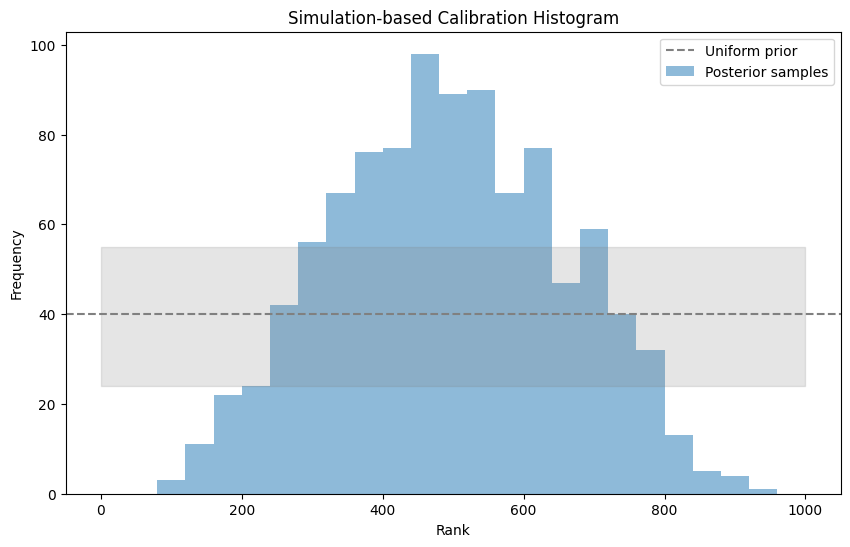

In [166]:
# Calculate the expected number of samples per bin under the uniform prior
uniform_prior_count = num_simulations / num_bins

# Calculate the 95% confidence interval using the binomial distribution
p = 1 / (num_bins + 1)
lower_bound = binom.ppf(0.005, num_simulations, p)
upper_bound = binom.ppf(0.995, num_simulations, p)

# Convert JAX arrays to NumPy arrays for compatibility with Matplotlib
# bin_edges_np = np.array(bin_edges)

midpoints = (bin_edges_np[:-1] + bin_edges_np[1:]) / 2

# Calculate histogram frequencies using numpy.histogram
sbc_histogram_np, _ = np.histogram(sbc_ranks, bins=bin_edges_np)

# Create the SBC plot
plt.figure(figsize=(10, 6))
plt.bar(midpoints, sbc_histogram_np, width=np.diff(bin_edges_np)[0], alpha=0.5, label="Posterior samples")
plt.axhline(uniform_prior_count, color="grey", linestyle="--", label="Uniform prior")
plt.fill_between(bin_edges_np, lower_bound, upper_bound, color="grey", alpha=0.2)

plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.title("Simulation-based Calibration Histogram")
plt.show()

## KS Test for SBC

In [20]:
# Two-sample Kolmogorov-Smirnov test
def ks_test(sample1, sample2):
    sample1_sorted = jnp.sort(sample1)
    sample2_sorted = jnp.sort(sample2)
    sample1_size = sample1.shape[0]
    sample2_size = sample2.shape[0]
    
    data_all = jnp.concatenate([sample1_sorted, sample2_sorted])
    group_indicator = jnp.concatenate([jnp.zeros(sample1_size), jnp.ones(sample2_size)])
    index_sorted = jnp.argsort(data_all)
    
    group_sorted = group_indicator[index_sorted]
    d_plus = jnp.where(group_sorted == 1, 1 / sample2_size, 0)
    d_minus = jnp.where(group_sorted == 0, 1 / sample1_size, 0)
    
    cdf_diff = jnp.cumsum(d_plus - d_minus)
    ks_statistic = jnp.max(jnp.abs(cdf_diff))
    
    # Compute p-value using asymptotic distribution
    n = sample1_size * sample2_size / (sample1_size + sample2_size)
    p_value = np.exp(-2 * n * ks_statistic**2)
    
    return ks_statistic, p_value

# Generate uniform samples
uniform_samples = jrandom.uniform(key, shape=(num_simulations,))

# Compute p-values using the Two-sample KS test
ks_statistic, p_value = ks_test(sbc_ranks / num_simulations, uniform_samples)
print("Kolmogorov-Smirnov statistic:", ks_statistic)
print("p-value:", p_value)

Kolmogorov-Smirnov statistic: 0.49000007
p-value: 0.0


## Data Averaged Posterior (DAP) vs. prior

In [21]:
theta_true = prior.sample(seed=key)
# Simulated data from likelihood
data_simulated = distrax.Normal(theta_true, sigma_true).sample(seed=key, sample_shape=1)
# Posterior approximation
approx_posterior = laplace_approximation(data_simulated)
posterior_samples = approx_posterior.sample(seed=key, sample_shape=(num_simulations,))

# Compute the Data-Averaged Posterior (DAP)
dap_samples = jnp.mean(posterior_samples, axis=0)

# Generate samples from the prior distribution
prior_samples = prior.sample(seed=key, sample_shape=(num_simulations,))

# Normalize the DAP samples and prior samples
min_value = jnp.min(jnp.concatenate([dap_samples, prior_samples]))
max_value = jnp.max(jnp.concatenate([dap_samples, prior_samples]))
dap_samples_normalized = (dap_samples - min_value) / (max_value - min_value)
prior_samples_normalized = (prior_samples - min_value) / (max_value - min_value)

# Combine the data and create labels
data_combined_dap = jnp.concatenate([dap_samples_normalized, prior_samples_normalized])[:, None]
labels_dap = jnp.concatenate([jnp.zeros(num_simulations), jnp.ones(num_simulations)])

# Compute the average cross-validated accuracy for DAP
dap_c2st_accuracy = cross_val_accuracy()
print("DAP Classifier 2-Sample Test (C2ST) accuracy:", dap_c2st_accuracy)

NameError: name 'sigma_true' is not defined

## Expected Coverage Probability (ECP)


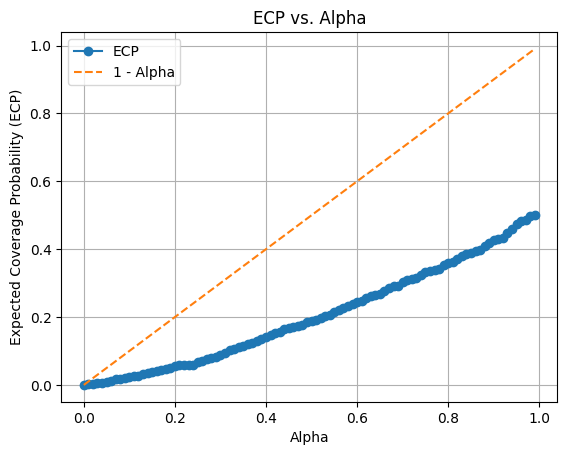

In [22]:
def expected_coverage_probability(sbc_ranks: jnp.ndarray, alpha: float) -> float:
    """
    Calculate the Expected Coverage Probability (ECP) for a given value of alpha.

    Args:
        sbc_ranks: A JAX numpy array containing the SBC ranks.
        alpha: A float value between 0 and 1.

    Returns:
        The Expected Coverage Probability (ECP) as a float.
    """
    num_simulations = sbc_ranks.shape[0]
    num_ranks_not_exceeding_alpha = jnp.sum(sbc_ranks / num_simulations <= alpha)
    ecp = num_ranks_not_exceeding_alpha / num_simulations
    return ecp


alpha_values = jnp.arange(0, 1., 0.01)
ecp_values = jax.vmap(lambda alpha: expected_coverage_probability(sbc_ranks, alpha))(alpha_values)

# for alpha, ecp in zip(alpha_values, ecp_values):
#     print(f"ECP for alpha {alpha:.1f}: {ecp:.2f}")

plt.plot(alpha_values, ecp_values, marker='o', label='ECP')
plt.plot(alpha_values, alpha_values, linestyle='--', label='1 - Alpha')

plt.xlabel('Alpha')
plt.ylabel('Expected Coverage Probability (ECP)')
plt.title('ECP vs. Alpha')

# plt.gca().invert_yaxis()

plt.legend()
plt.grid()
plt.show()


## SBC Function Check Using SBI example

In [23]:
import jax.scipy.optimize
from jax.scipy.stats import norm

num_dim = 2
num_simulations = 5_000

prior_mean = jnp.ones(num_dim)
prior_cov = 2 * jnp.eye(num_dim)
prior = distrax.MultivariateNormalFullCovariance(loc=prior_mean, covariance_matrix=prior_cov)

default_likelihood_loc = 0.0  # let's start with 0 shift
default_likelihood_scale = 0.01  # let's smear theta only by a little bit

# def likelihood(data, mu):
#     return distrax.Normal(mu, sigma_true).log_prob(data)

def simulator(rng_key, theta, loc=default_likelihood_loc, scale=default_likelihood_scale):
    """linear gaussian inspired by sbibm
    https://github.com/sbi-benchmark/sbibm/blob/15f068a08a938383116ffd92b92de50c580810a3/sbibm/tasks/gaussian_linear/task.py#L74
    """
    num_dim = theta.shape[-1]
    cov_ = scale * jnp.eye(num_dim)  # always positively semi-definite

    mvn = distrax.MultivariateNormalFullCovariance(loc=(theta + loc), covariance_matrix=cov_)
    
    value, log_prob = mvn.sample_and_log_prob(seed=rng_key, sample_shape=(num_data_points,))

    return value, log_prob

def simulator_log_prob(theta, loc=default_likelihood_loc, scale=default_likelihood_scale):
    num_dim = theta.shape[-1]
    cov_ = scale * jnp.eye(num_dim)  # always positively semi-definite

    mvn = distrax.MultivariateNormalFullCovariance(
        loc=(theta + loc), covariance_matrix=cov_)
    
    return mvn.log_prob(theta)


# Approximate posterior using Laplace approximation
def laplace_approximation(data):
    def negative_log_posterior(mu):
        return (-prior.log_prob(mu) - simulator_log_prob(mu)).sum()

    mu_init = jnp.array([0.0])
    mu_approx = jax.scipy.optimize.minimize(negative_log_posterior, mu_init, method="BFGS").x
    hessian = jax.hessian(negative_log_posterior)(mu_approx)
    std_approx = jnp.sqrt(1 / hessian)
    return distrax.Normal(mu_approx[0], std_approx[0])

# Generate synthetic data
key = jrandom.PRNGKey(42)

# Simulation-based calibration
num_simulations = 1_000
num_data_points = 1_000
keys = jrandom.split(key, num_simulations)

def sbc_iteration(key):
    # True theta values to use
    theta_true = prior.sample(seed=key)
    # Simulated data from likelihood
    data_simulated, _ = simulator(key, theta_true)
    # Posterior approximation
    approx_posterior = laplace_approximation(data_simulated)
    posterior_samples = approx_posterior.sample(seed=key, sample_shape=(num_data_points,))
    # posterior_data_simulated = distrax.Normal(posterior_samples, sigma_true).sample(seed=key, sample_shape=1)
    # Rank of the sample
    rank = jnp.sum(posterior_samples < theta_true)
    return rank

num_bins = num_simulations // 40
bin_edges = jnp.linspace(0, num_data_points, num_bins + 1)
bin_edges_np = np.array(bin_edges)
midpoints = (bin_edges[1:] + bin_edges[:-1]) / 2.

sbc_ranks = jax.vmap(sbc_iteration)(keys)
sbc_histogram_np, _ = np.histogram(sbc_ranks, bins=bin_edges_np)


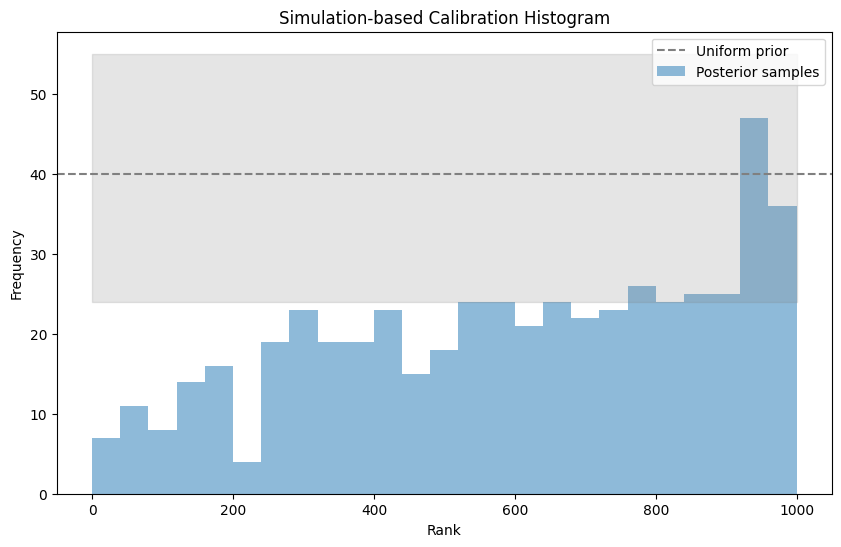

In [24]:
# Calculate the expected number of samples per bin under the uniform prior
uniform_prior_count = num_simulations / num_bins

# Calculate the 95% confidence interval using the binomial distribution
p = 1 / (num_bins + 1)
lower_bound = binom.ppf(0.005, num_simulations, p)
upper_bound = binom.ppf(0.995, num_simulations, p)

# Convert JAX arrays to NumPy arrays for compatibility with Matplotlib
# bin_edges_np = np.array(bin_edges)

midpoints = (bin_edges_np[:-1] + bin_edges_np[1:]) / 2

# Calculate histogram frequencies using numpy.histogram
sbc_histogram_np, _ = np.histogram(sbc_ranks, bins=bin_edges_np)

# Create the SBC plot
plt.figure(figsize=(10, 6))
plt.bar(midpoints, sbc_histogram_np, width=np.diff(bin_edges_np)[0], alpha=0.5, label="Posterior samples")
plt.axhline(uniform_prior_count, color="grey", linestyle="--", label="Uniform prior")
plt.fill_between(bin_edges_np, lower_bound, upper_bound, color="grey", alpha=0.2)

plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.title("Simulation-based Calibration Histogram")
plt.show()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

def plot_sbc_histogram(sbc_histogram, num_simulations, num_bins=None):
    """
    Plot the simulation-based calibration (SBC) histogram.

    Args:
        sbc_histogram: A NumPy array representing the SBC histogram of rank statistics.
        num_simulations: An integer representing the number of simulations performed for the SBC.
        num_bins: An optional integer representing the number of bins in the histogram. 
                  If not provided, it will be calculated as num_simulations // 20.
    """
    if num_bins is None:
        num_bins = num_simulations // 20

    # Define the bin edges for the histogram
    bin_edges = np.linspace(0, num_simulations, num_bins + 1)

    # Calculate the expected number of samples per bin under the uniform prior
    uniform_prior_count = num_simulations / num_bins

    # Calculate the 95% confidence interval using the binomial distribution
    p = 1 / (num_bins + 1)
    lower_bound = binom.ppf(0.005, num_simulations, p)
    upper_bound = binom.ppf(0.995, num_simulations, p)

    # Create the SBC plot
    plt.figure(figsize=(10, 6))
    plt.bar(bin_edges[:-1], sbc_histogram, width=np.diff(bin_edges)[0], alpha=0.5, label="Posterior samples")
    plt.axhline(uniform_prior_count, color="grey", linestyle="--", label="Uniform prior")
    plt.fill_between(bin_edges, lower_bound, upper_bound, color="grey", alpha=0.2)

    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title("Simulation-based Calibration Histogram")
    plt.show()



ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (50,) and arg 1 with shape (25,).

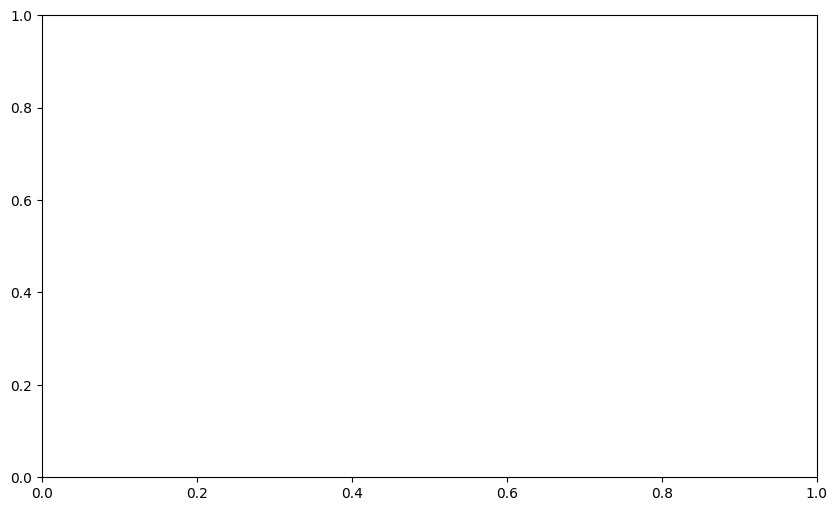

In [26]:
plot_sbc_histogram(sbc_histogram_np, num_simulations=1000)

In [99]:
theta_true = prior.sample(seed=keys[0])
# Simulated data from likelihood
data_simulated = distrax.Normal(theta_true, sigma_true).sample(seed=keys[0], sample_shape=1)
# Posterior approximation
approx_posterior = laplace_approximation(data_simulated)
posterior_samples = approx_posterior.sample(seed=keys[0], sample_shape=(num_data_points,))
posterior_data_simulated = distrax.Normal(posterior_samples, sigma_true).sample(seed=keys[0], sample_shape=1)
# Rank of the sample
rank = jnp.sum(posterior_samples < theta_true)


In [104]:
rank

DeviceArray(254, dtype=int32)